# Scale selection with the convexity defect function 

### Dependencies
This notebook was tested using:

- numpy 1.19.1
- scipy 1.5.2
- gudhi 2.3.0
- matplotlib 3.0.2
- rpforest 1.6

### Notebook global settings

In [1]:
%matplotlib inline

## i) The $t$-convex hull

Let $\mathcal{X}_n$ be a set of $n$ points in $\mathbb{R}^D$, that lies close to some object $M$. Our goal is to reconstruct the set $M$. To do so, we need to make some assumptions on the object $M$. For instance, if we assume that $M$ is a linear subspace, using a PCA may be a good idea to recover $M$. If we assume that $M$ is convex, a natural idea is to consider the convex hull $\mathrm{Conv}(\mathcal{X}_n)$ of the dataset.

We will here make a different kind of assumption: we will assume that $M$ is a manifold, that is an object that locally looks like a flat space. In this case, we propose a notion of local convex hull to reconstruct $M$. Given $t>0$, the $t$-convex hull $\mathrm{Conv}(t,\mathcal{X}_n)$ of the set $\mathcal{X}_n$ is defined in the following way:
 - for each subset $\sigma\subset \mathcal{X}_n$, we let $r(\sigma)$ be the radius of the smallest enclosing ball of $\sigma$.
 - the set $\mathrm{Conv}(t,\mathcal{X}_n)$ is equal to the union of the sets $\mathrm{Conv}(\sigma)$ for which $r(\sigma)\leq t$.
 
We display the $t$-convex hull of a set $\mathcal{X}_n$ close to the unit circle $M$.

In [12]:
import numpy as np
import gudhi as gd
from scipy.spatial import KDTree
from create_samples import sample_bean, sample_circle
from utils import *
import matplotlib.pyplot as plt


n = 100
gam = 0.02 # The noise level
X = sample_circle(n) + gam*np.random.uniform(low = -1, high = 1, size = (n,2))

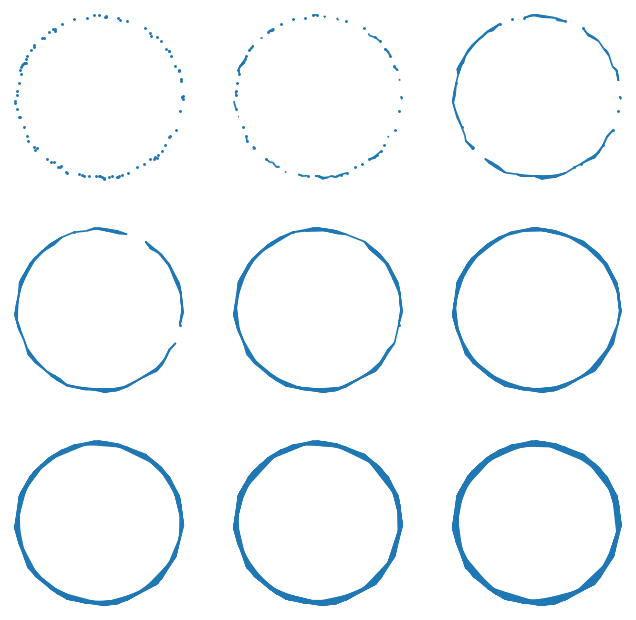

In [13]:
# The different scales t displayed (takes approx. 20sec)
K = 3
tmax = 0.3
scales = np.linspace(0, tmax, K**2)

kdtree = KDTree(X)

fig, ax = plt.subplots(K, K, figsize = (10,10), dpi = 80, frameon = False)
xmax = 1.1
xmin = -1.1
lim_x = [xmin, xmax]
lim_y = [xmin, xmax]
for i in range(K):
    for j in range(K):
        add_t_hull(ax[i,j], X, kdtree, scales[K*i+j])
        ax[i,j].set_xlim(lim_x)
        ax[i,j].set_ylim(lim_y)
plt.show()


## ii) The convexity defect function

It appears with the previous experiment that not all values of $t$ have the same quality to reconstruct the manifold $M$. For $t$ too small, there are ''holes'' in the $t$-convex hull, whereas for $t$ larger than some threshold $t^*(\mathcal{X}_n)$ there are no ''holes'' anymore, and the scale $t$ then becomes acceptable. 

One can actually show that this threshold $t^*(\mathcal{X}_n)$ is close to the approximation rate $\varepsilon(\mathcal{X}_n) = d_H(\mathcal{X}_n,M)$, the Hausdorff distance between the sample and the manifold.

We propose to automatically select a good scale $t$ by computing the convexity defect function of the set $\mathcal{X}_n$, which is defined by the relation $h(t,\mathcal{X}_n) = d_H(\mathrm{Conv}(\mathcal{X}_n),\mathcal{X}_n)$. The convexity defect function is a piecewise-constant non-decreasing function, that satisfies $0\leq h(t,\mathcal{X}_n) \leq t$. It exhibits two different behaviors depending on the value of $t$.

For $t$ smaller than $t^*(\mathcal{X}_n)$, the convexity defect function stays very close to its maximal value (that is $h(t,\mathcal{X}_n)$ is close to $t$). On the contrary, for $t$ above $t^*(\mathcal{X}_n)$ (but not too large), the convexity defect function becomes almost constant! We use this phenomenon to select a scale $t$ that is a little bit above $t^*(\mathcal{X}_n)$.

More precisely, we choose a slope $\lambda \in (0,1)$ and let $t_\lambda(\mathcal{X}_n)$ be the first intersection point between the graph of the convexity defect function and the line of slope $\lambda$.

In [14]:
tmax = 0.4 # h(t,X) is computed up to t = tmax

# Build a RP-tree on top of X. Used to find nearest neighbors
model = RPForest(leaf_size = 500, no_trees = 100)
model.fit(X)
tree = model

# radii = List of t = r(sigma) for sigma in the set, convexity_defect = associated values of h(t,X)
radii, convexity_defect = conv_defect(X, tree, tmax) 

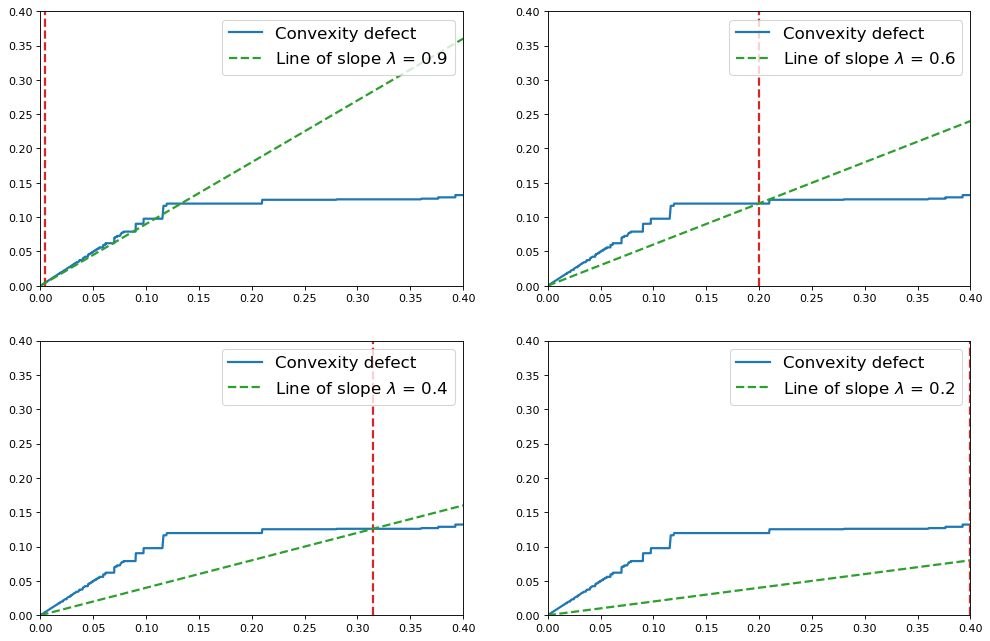

In [15]:
slopes = [0.9, 0.6, 0.4, 0.2]
K = 2

# Compute t_lambda for different slopes 
t_lambda = [t_opt(l, radii, convexity_defect) for l in slopes]
xmax = min(0.4, tmax)

fig, ax = plt.subplots(K, K, figsize = (15,10), dpi = 80, frameon = False)

for i in range(K):
    for j in range(K):
        lambd = slopes[K*i+j]
        ax[i,j].plot(radii, convexity_defect, color = 'tab:blue', linewidth = 2, label = 'Convexity defect')

        ax[i,j].plot([t_opt(lambd, radii, convexity_defect), t_opt(lambd, radii, convexity_defect)], [0,xmax],
                     '--',  color='tab:red', linewidth=2)
        ax[i,j].plot([0,xmax], [0,lambd*xmax], '--', color = 'tab:green', 
                     linewidth = 2, label='Line of slope $\lambda$ = ' + str(lambd))
        ax[i,j].legend(loc = 'upper right', fontsize = 15)

        props = dict(boxstyle = 'square', facecolor = 'white',  alpha = 0.5)

        # Decoration
        ax[i,j].set_xlim([0, xmax])
        ax[i,j].set_ylim([0, xmax])


## iii) The slope heuristics

The above figure shows that the choice of the slope $\lambda$ has a huge impact on the selection procedure. If $\lambda$ is too close to $1$, then the selected scale will be too small, whereas if $\lambda$ is too close to $0$, then the slope of line $\lambda$ will never touch the convexity defect function (or hit it at a very large scale $t$).

We propose the slope heuristics to choose the parameter $\lambda$. It follows from the following observations. When $\lambda$ is too close to $1$, the value of the selected $t$ will go very quickly to $0$. On the contrary, when for ''good'' values of $\lambda$, the value of the selected $t$ will change smoothly with respect to $\lambda$. One can actually show that for ''good'' values of $\lambda$, the selected scale $t_{\lambda}(\mathcal{X}_n)$ varies as $1/\lambda$.

We use this behavior to select a slope $\lambda$, by displaying the function $g:\lambda \mapsto 1/t_{\lambda}(\mathcal{X}_n)$. This function will exhibit a ''jump'' at some value $\lambda_{\max}$ close to $1$: this is where $t_{\lambda}(\mathcal{X}_n)$ starts going very quickly to $0$. Any value of $\lambda$ just below the jump is admissible. In practice, we detect the jump by selecting the smallest $\lambda$ such that $g(\lambda^+)-g(\lambda^-) > g(0.5)$, while we then choose $\lambda_{\text{choice}} = 0.8\lambda_{\max}$.

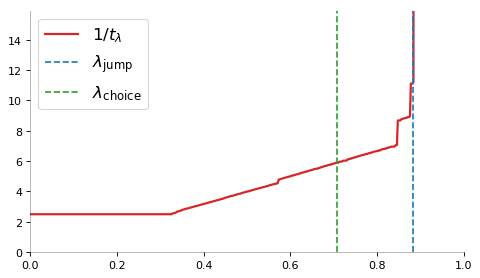

Lambda max: 0.8837675350701402
Selected value of lambda: 0.7070140280561121


In [16]:
K = 500
slopes = np.linspace(0,1,K).reshape((K,1))
y = [1/t_opt(l, radii, convexity_defect) for l in slopes]

size_jump = 1/t_opt(0.5, radii, convexity_defect)
ind_max = np.argmax((np.diff(y)>size_jump))
lambd_max = slopes[ind_max,0]
lambd = lambd_max*0.8


plt.figure(figsize = (7,4), dpi =  80)

plt.plot(slopes, y, color = 'tab:red',  linewidth = 2, label = '$1/t_\lambda$')
plt.plot([lambd_max,lambd_max],[0,4/t_opt(0.5, radii, convexity_defect)],  '--',
         color = 'tab:blue', label = '$\lambda_{\mathrm{jump}}$')
plt.plot([lambd,lambd],[0,4/t_opt(0.5,radii, convexity_defect)], '--',
         color = 'tab:green', label = '$\lambda_{\mathrm{choice}}$')

plt.ylim(0, 4/t_opt(0.5,radii, convexity_defect))
plt.xlim(0, 1)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)   

plt.legend(loc='upper left', fontsize = 15)
plt.show()


print('Lambda max: ' + str(slopes[ind_max,0]))
print('Selected value of lambda: ' + str(lambd))

(-1.1, 1.1)

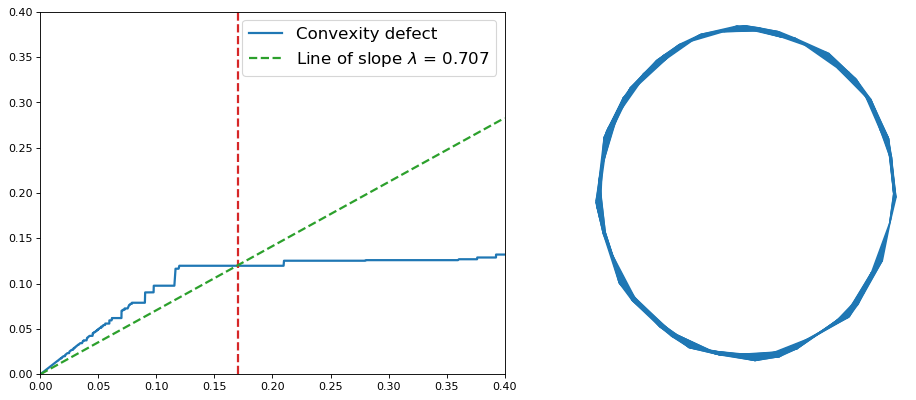

In [17]:
# Display the convexity defect function and the line of slope \lambda_choice

fig, ax = plt.subplots(1,2, figsize = (14,6), gridspec_kw={
                           'width_ratios': [2,1.4],
                           'height_ratios': [1]},
                       dpi = 80, frameon = False)
xmax = min(0.4,tmax)

ax[0].plot(radii, convexity_defect, color = 'tab:blue', linewidth = 2, label = 'Convexity defect')

ax[0].plot([t_opt(lambd, radii, convexity_defect), t_opt(lambd, radii, convexity_defect)], [0,xmax],
             '--',  color = 'tab:red', linewidth = 2)
ax[0].plot([0,xmax], [0,lambd*xmax], '--', color = 'tab:green', 
             linewidth = 2, label = 'Line of slope $\lambda$ = ' + str(np.around(lambd,3)))
ax[0].legend(loc = 'upper right', fontsize = 15)

props = dict(boxstyle = 'square', facecolor = 'white',  alpha = 0.5)

# Decoration
ax[0].set_xlim([0, xmax])
ax[0].set_ylim([0, xmax])

add_t_hull(ax[1], X, kdtree, t_opt(lambd, radii, convexity_defect))
ax[1].set_xlim(lim_x)
ax[1].set_ylim(lim_y)


## iv) Speeding up the process

Computing the whole convexity defect function is computationally expensive. However, to select $t_{\lambda}(\mathcal{X}_n)$, one can stop at the first value $t$ such that $h(t,\mathcal{X}_n) <\lambda t$. This can be used to speed up the process. We first compute the convexity defect function up to some maximal scale $t_1$ and compute $\lambda_{\text{choice}}$. If the selected value of $t$ with this procedure is equal to $t_1$, then it means that we did not go far enough in the computation of the convexity defect function, and we replace $t_1$ by a larger scale $t_2$, eventually stoping when the selected value is smaller than the maximal scale.

The successive values $t_i$ are chosen to be equal to the minimal distance between a point and its $2^i$ nearest neighbor.

In [18]:
n = 200 # roughly same speed as before but twice as many points
gam = 0.02 # The noise level
X = sample_circle(n) + gam*np.random.uniform(low = -1, high = 1, size = (n,2))

radii, convexity_defect, tsel, lambd, n_neigh, tmax = select_t(X)

print('Maximal number of neighbors: ' + str(n_neigh))
print('Maximal scale: ' + str(tmax))
print('Selected slope: ' + str(lambd))
print('Selected scale: ' + str(tsel))

Maximal number of neighbors: 32
Maximal scale: 0.17352002083583706
Selected slope: 0.6793969849246232
Selected scale: 0.11835082951539078


(-1.1, 1.1)

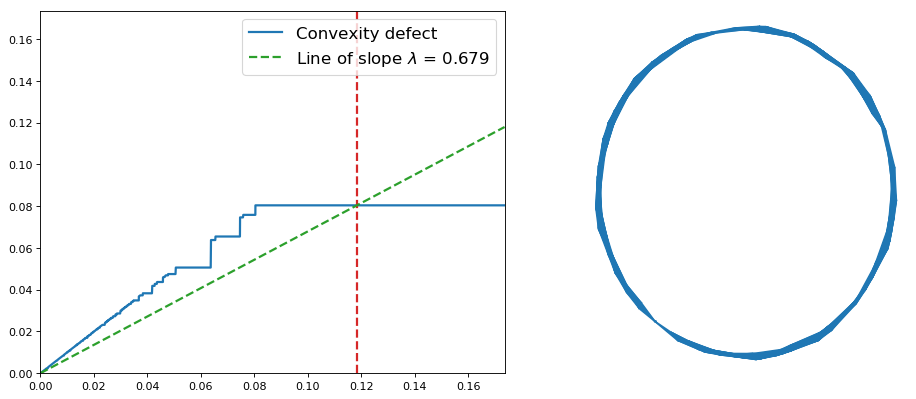

In [19]:
kdtree = KDTree(X)

fig, ax = plt.subplots(1,2, figsize = (14,6), gridspec_kw = {
                           'width_ratios': [2,1.4],
                           'height_ratios': [1]},
                       dpi = 80, frameon = False)

ax[0].plot(radii, convexity_defect, color = 'tab:blue', linewidth = 2, label = 'Convexity defect')

ax[0].plot([t_opt(lambd, radii, convexity_defect), t_opt(lambd, radii, convexity_defect)], [0,tmax],
             '--',  color = 'tab:red', linewidth=2)
ax[0].plot([0,tmax],[0,lambd*tmax], '--', color = 'tab:green', 
             linewidth = 2, label = 'Line of slope $\lambda$ = ' + str(np.around(lambd,3)))
ax[0].legend(loc = 'upper right', fontsize = 15)

props = dict(boxstyle = 'square', facecolor = 'white',  alpha = 0.5)

# Decoration
ax[0].set_xlim([0, tmax])
ax[0].set_ylim([0, tmax])

add_t_hull(ax[1], X, kdtree, t_opt(lambd, radii, convexity_defect))
ax[1].set_xlim(lim_x)
ax[1].set_ylim(lim_y)